**Содержание**<a id='toc0_'></a>    
- [**Проект: Телекоммуникации. Прогнозирование оттока клиентов с помощью машинного обучения.**](#toc1_)    
  - [Библиотеки](#toc1_1_)    
  - [Загрузка и изучение датасетов.](#toc1_2_)    
        - [Загрузка](#toc1_2_1_1_1_)    
        - [О датасете contract](#toc1_2_1_1_2_)    
        - [О датасете personal](#toc1_2_1_1_3_)    
        - [О датасете internet](#toc1_2_1_1_4_)    
        - [О датасете phone](#toc1_2_1_1_5_)    
  - [Объединение данных](#toc1_3_)    
  - [Работа с пропусками](#toc1_4_)    
  - [Преобразование данных и создание признаков.](#toc1_5_)    
  - [Анализ](#toc1_6_)    
  - [Подготовка данных](#toc1_7_)    
  - [LGBM](#toc1_8_)    
  - [CatBoost](#toc1_9_)    
  - [Тестирование](#toc1_10_)    
  - [Важность признаков и матрица ошибок](#toc1_11_)    
  - [Вывод](#toc1_12_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->


# <a id='toc1_'></a>[**Проект: Телекоммуникации. Прогнозирование оттока клиентов с помощью машинного обучения.**](#toc0_)

**ТЗ:**  Оператор связи хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, компании нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Задача — обучить на этих данных модель для прогноза оттока клиентов.

**Описание услуг**

Оператор предоставляет два основных типа услуг:

- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:

- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

*Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.*

**Описание данных**

*Данные состоят из нескольких файлов, полученных из разных источников:*

- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиента;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии.

**Метрика** - ROC AUC >= 0.85

## <a id='toc1_1_'></a>[Библиотеки](#toc0_)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

RANDOM_STATE = 201123

## <a id='toc1_2_'></a>[Загрузка и изучение датасетов.](#toc0_)

##### <a id='toc1_2_1_1_1_'></a>[Загрузка](#toc0_)

In [2]:
try:
    contract = pd.read_csv(r'C:\Users\Admin\Downloads\contract_new.csv')
    personal = pd.read_csv(r'C:\Users\Admin\Downloads\personal_new.csv')
    internet = pd.read_csv(r'C:\Users\Admin\Downloads\internet_new.csv')
    phone = pd.read_csv(r'C:\Users\Admin\Downloads\phone_new.csv')
except:
    contract = pd.read_csv('/datasets/contract_new.csv')
    personal = pd.read_csv('/datasets/personal_new.csv')
    internet = pd.read_csv('/datasets/internet_new.csv')
    phone = pd.read_csv('/datasets/phone_new.csv')

##### <a id='toc1_2_1_1_2_'></a>[О датасете contract](#toc0_)

In [3]:
print('Датасет - информация о договоре (contract)\n')
print(contract.info())
print()
print('Отображение первых 10 строк датасета\n')
display(contract.head(10))
print()
print('Пропуски: \n', contract.isna().sum())
print()
print('Дубликаты: \n', contract.duplicated().sum())

Датасет - информация о договоре (contract)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None

Отображение первых 10 строк датасета



,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35



Пропуски: 
 customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

Дубликаты: 
 0


**Сводка по датасету contract:**
    
    -7043 строки и 8  столбцов:
        -customerID — идентификатор абонента;
        - BeginDate — дата начала действия договора;
        - EndDate — дата окончания действия договора;
        - Type — тип оплаты: раз в год-два или ежемесячно;
        - PaperlessBilling — электронный расчётный лист;
        - PaymentMethod — тип платежа;
        - MonthlyCharges — расходы за месяц;
        - TotalCharges — общие расходы абонента
      
- Пропуски и дубликаты отсутсвуют. 

##### <a id='toc1_2_1_1_3_'></a>[О датасете personal](#toc0_)

In [4]:
print('Датасет - персональные данные клиента (personal)\n')
print(personal.info())
print()
print('Отображение первых 10 строк датасета\n')
display(personal.head(10))
print()
print('Пропуски: \n', personal.isna().sum())
print()
print('Дубликаты: \n', personal.duplicated().sum())

**Сводка по датасету personal:**

    - 7043 строки и 5 столбцов:
        
        - customerID — идентификатор пользователя;
        - gender — пол;
        - SeniorCitizen — является ли абонент пенсионером;
        - Partner — есть ли у абонента супруг или супруга;
        - Dependents — есть ли у абонента дети.
- Пропуски и дубликаты отсутствуют. 

##### <a id='toc1_2_1_1_4_'></a>[О датасете internet](#toc0_)

In [5]:
print('Датасет - информация об интернет-услугах (internet)\n')
print(internet.info())
print()
print('Отображение первых 10 строк датасета\n')
display(internet.head(10))
print()
print('Пропуски: \n', internet.isna().sum())
print()
print('Дубликаты: \n', internet.duplicated().sum())

**Сводка по датасету internet:**

    - 5517 строк и 8 столбцов:
        
        - customerID — идентификатор пользователя;
        - InternetService — тип подключения;
        - OnlineSecurity — блокировка опасных сайтов;
        - OnlineBackup — облачное хранилище файлов для резервного копирования данных;
        - DeviceProtection — антивирус;
        - TechSupport — выделенная линия технической поддержки;
        - StreamingTV — стриминговое телевидение;
        - StreamingMovies — каталог фильмов.
- Пропуски и дубликаты отсутствуют. 

##### <a id='toc1_2_1_1_5_'></a>[О датасете phone](#toc0_)

In [6]:
print('Датасет - информация об услугах телефонии (phone)\n')
print(phone.info())
print()
print('Отображение первых 10 строк датасета\n')
display(phone.head(10))
print()
print('Пропуски: \n', phone.isna().sum())
print()
print('Дубликаты: \n', phone.duplicated().sum())

**Сводка по датасету phone:**

    - 6361 строка и 2 столбца:
        
        - customerID — идентификатор пользователя;
        - MultipleLines — подключение телефона к нескольким линиям одновременно.
- Пропуски и дубликаты отсутствуют. 

**Краткий итог по изучению полученных данных:**

    - В датасетах отстуствуют дубликаты и пропуски. 
    - Имеют разную размерность. 
    - Некоторые столбцы требуют преобразования в подходящий формат. 
    - Во всех датасетах есть общий столбец customerID - по которому в дальнейшем будет произведено объеденение данных. 

## <a id='toc1_3_'></a>[Объединение данных](#toc0_)

In [8]:
data = (
    contract.merge(personal, on = 'customerID', how='inner')
    .merge(internet, on = 'customerID', how='outer')
    .merge(phone, on = 'customerID', how='outer')
)
display(data.head(10))
data.info()
print('Дубликаты:', data.duplicated().sum())

- Произвели объединение датасетов в один с помощью метода megre() по столбцу customerID. 
- Количество строк не изменилось.
- После объединения появились пропуски у тех клиентов, которые не пользуются интернетом или телефоном. Дубликатов нет. 

## <a id='toc1_4_'></a>[Работа с пропусками](#toc0_)

In [9]:
data.isna().sum()

In [10]:
data['MultipleLines'] = data['MultipleLines'].fillna('PH')
internet = (['InternetService', 'OnlineSecurity', 'OnlineBackup', 
             'DeviceProtection', 'TechSupport' ,'StreamingTV', 'StreamingMovies'])
data[internet]= data[internet].fillna('WEB') #так короче чем internet 
data.info()

- Замена пропусков в столбце MultipleLines - на PH (PHONE) - только телефония
- Замена пропусков с интернет подключением на WEB - только интернет услуги. 

## <a id='toc1_5_'></a>[Преобразование данных и создание признаков.](#toc0_)

Так как у нас стоит задача прогноз оттока клиентов, мы возьем для формирования признака столбец с датой окончания договора. 

Сформируем признак следующим образом:

- если в строк столбца указанно значение "NO" - поставим 1, так как это действующий клиент. 
- если в строке столбца нет значения "NO" - ставим 0, т.к. клиент прикратил пользоваться услугами. 

In [11]:
data.loc[data['EndDate'] == 'No', 'target'] = 1
data.loc[data['EndDate'] != 'No', 'target'] = 0
# check
display(data.head(10))
data.info()

In [12]:
data.loc[data['EndDate'] == 'No', 'EndDate'] ='2020-02-01'

Заменили в столбце с датами окончаниями договора, на дату выгрузки данных, указанных в условии задачи. 

Теперь займемся перевода столбцов в подходящий для них тип данных. 

In [13]:
data['target'] = data['target'].astype('int')
data['EndDate'] = pd.to_datetime(data['EndDate'], format='%Y-%m-%d')
data['BeginDate'] = pd.to_datetime(data['BeginDate'], format='%Y-%m-%d')
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data.info()



In [14]:
data['TotalCharges'].isna().sum()

In [15]:
data.dropna(axis=0, inplace=True)
data.info()

In [16]:
data['TotalCharges'].head()

Краткая сводка:

    Выделили целевой признак в столбец target
    Сделали преобразование данных в нужный формат. Даты привели к датам, целевой признак привели к численному формату. 
    Преобразовали столбец TotalCharges методом to_numeric в численный формат. Numeric выбран потому что, там не просто целые числа, к тому же там были пропуски. 
    О пропусках: в столбце TotalCharges - 11 пропусков, так как это не критичное количество данных, решено было их удалить. 

Добавим признак, который будет отображать кол-во дней пользования сервисом. 

In [17]:
data['count_day']=(data['EndDate'] - data['BeginDate']).dt.days
data.head()

Больше столбцы с датами нам не понадобятся, уберем их с датасета. Также уберем customerID. 

In [18]:
data.drop(['EndDate','BeginDate', 'customerID'], axis=1, inplace =True)
data.info()

In [19]:
data.duplicated().sum()

In [20]:
data = data.drop_duplicates()

После удаления лишних столбцов - образовались дублирующие строки, мы их удалили. 

## <a id='toc1_6_'></a>[Анализ](#toc0_)

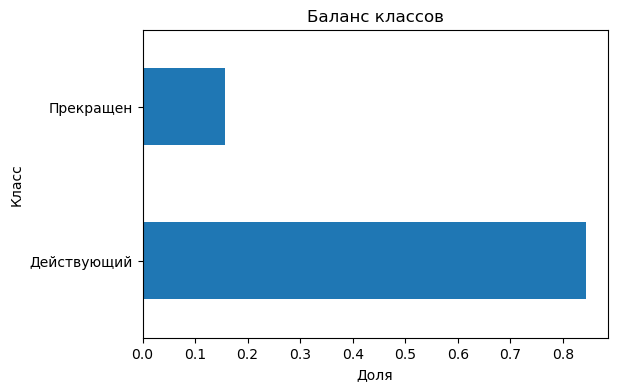

In [21]:
# Посмотрим на дисбаланс классов
plt.figure(figsize=(6, 4))
data['target'].value_counts(normalize=True).plot(kind='barh')
plt.xlabel('Доля')
plt.ylabel('Класс')
plt.title('Баланс классов')
plt.yticks([0, 1], ['Действующий', 'Прекращен'])
plt.show()
data['target'].value_counts(normalize=True)

Мы видим сильный дисбаланс классов, но по условию ТЗ, наша метрика AUC-ROC - которая устойчива к дисбалансу, поэтому можно оставить данные в таком виде. 

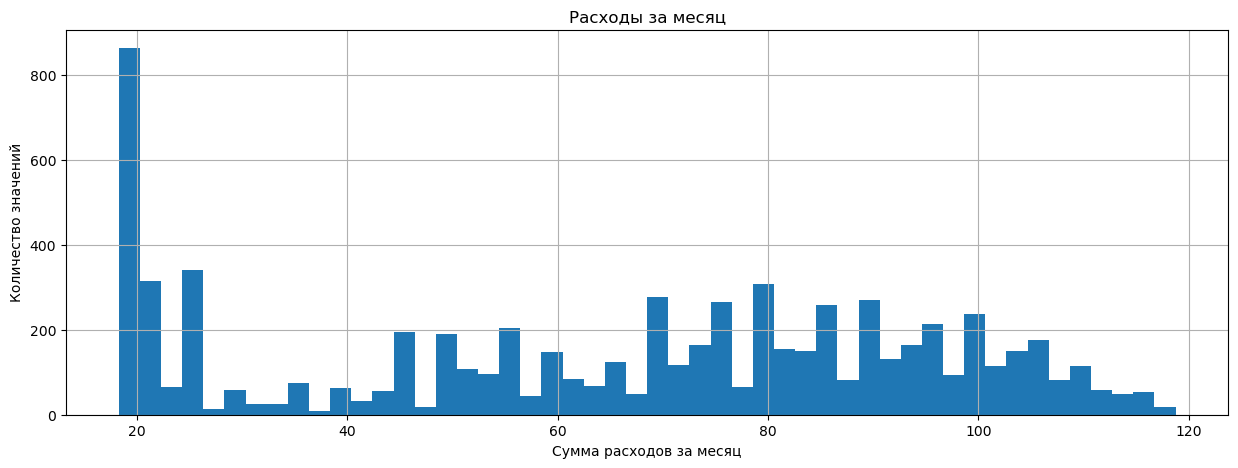

In [22]:
# Посмотрим расходы за месяц
data['MonthlyCharges'].hist(bins=50, figsize=(15,5))
plt.title('Расходы за месяц')
plt.xlabel('Сумма расходов за месяц')
plt.ylabel('Количество значений');

На гистограмме отчетливо виден всплекс рассходов на отметке 20. Вероятно, большая часть клиентов использует только базовый пакет предоставления услуг. 

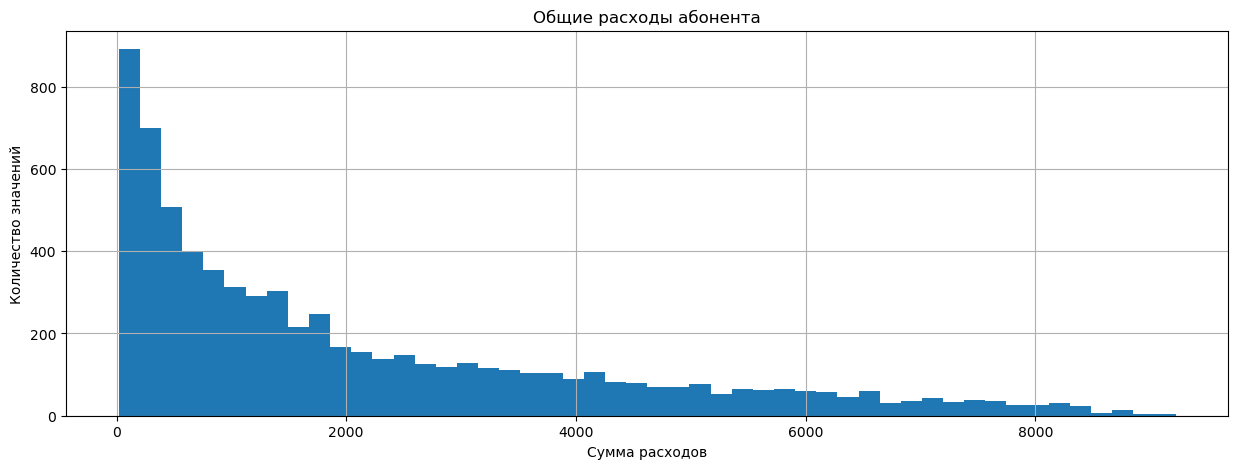

In [23]:
# Посмотрим общие расходы 
data['TotalCharges'].hist(bins=50, figsize=(15,5))
plt.title('Общие расходы абонента')
plt.xlabel('Сумма расходов')
plt.ylabel('Количество значений');

Все логично и подкрепляется гистограммой выше. Что большинство пользователей используют базовые тарифы оплаты. Чем больше расходов ложиться на клиента, тем меньше таких контрактов заключается. 

а) Не каждый может себе позволить максимальный тариф

б) Не требуются продвинутые опции

в) Включает и "а" и "б" пункты вместе

In [24]:
# Выведем все категориальные признаки
categorical_columns = data.select_dtypes(include=['object']).columns.tolist()
categorical_columns

In [25]:
categorical_columns = categorical_columns + ['SeniorCitizen'] # один чуть не потеряли
categorical_columns

Отлично, все признаки в сборе, теперь подготовим функцию для отрисовки распределения по каждому признаку. 

In [26]:
def check_category (data, categorical_columns):
    fig, ax = plt.subplots(figsize=(12, 5))
    sns.countplot(x=categorical_columns, hue='target', data=data, palette="pastel")
    ax.set_title('Распределение по ' + categorical_columns)
    plt.ylabel('Количество');

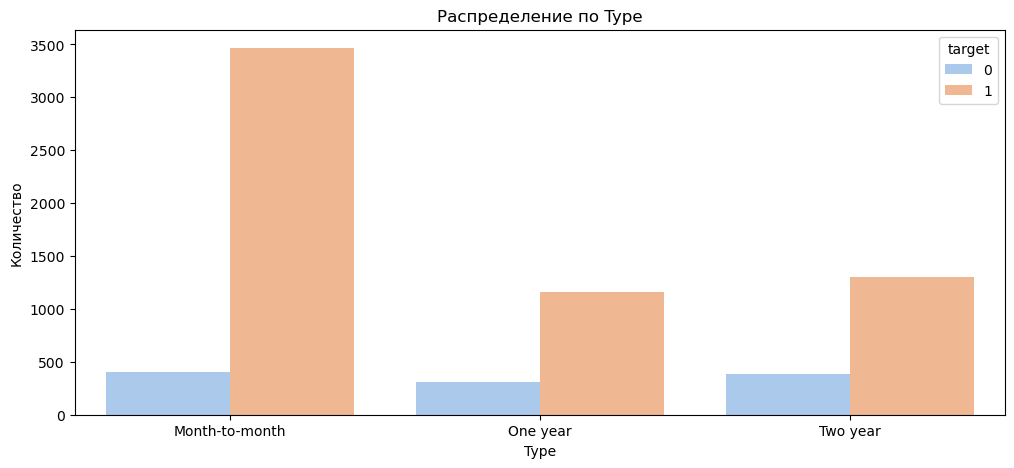

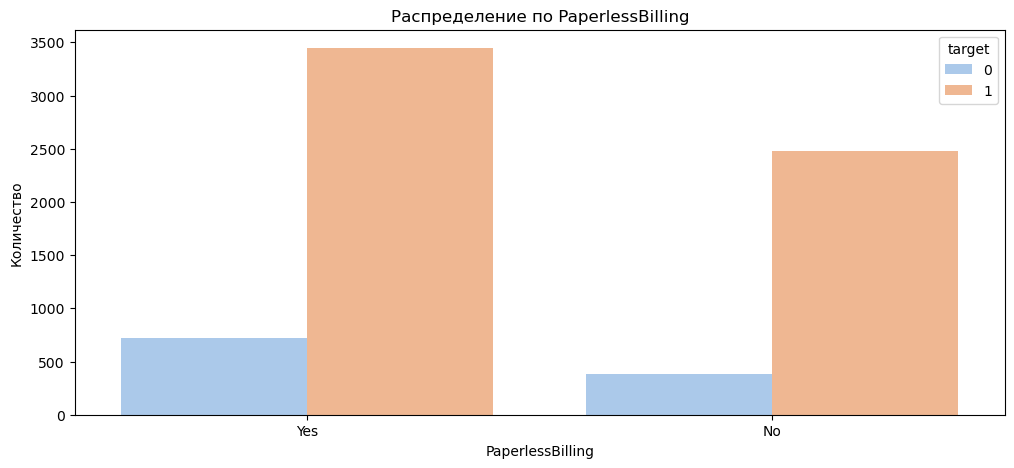

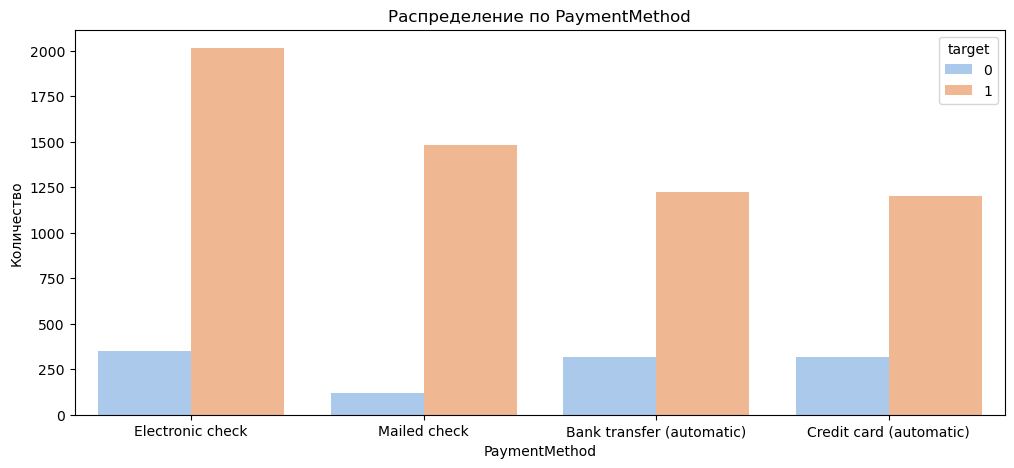

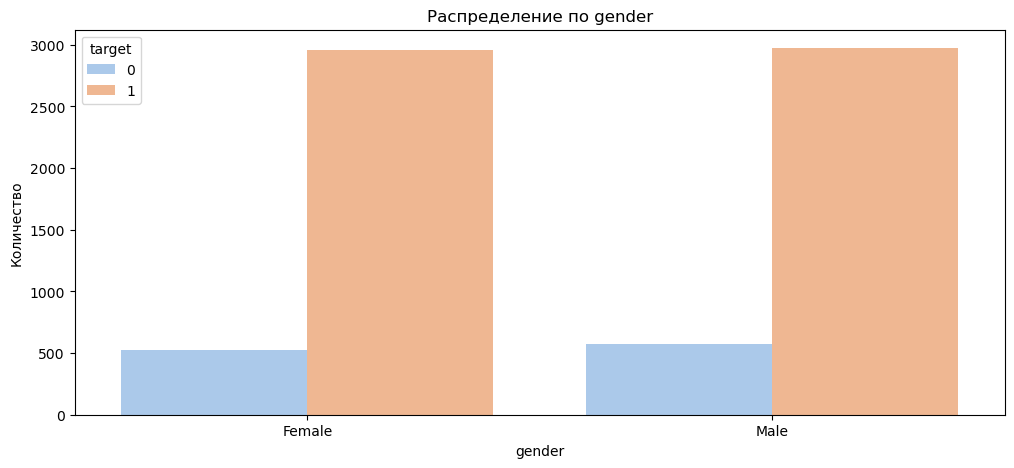

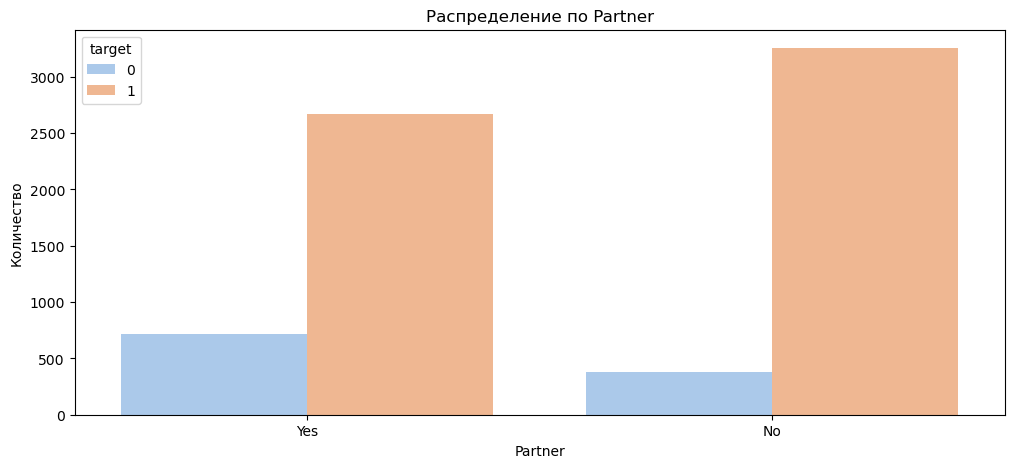

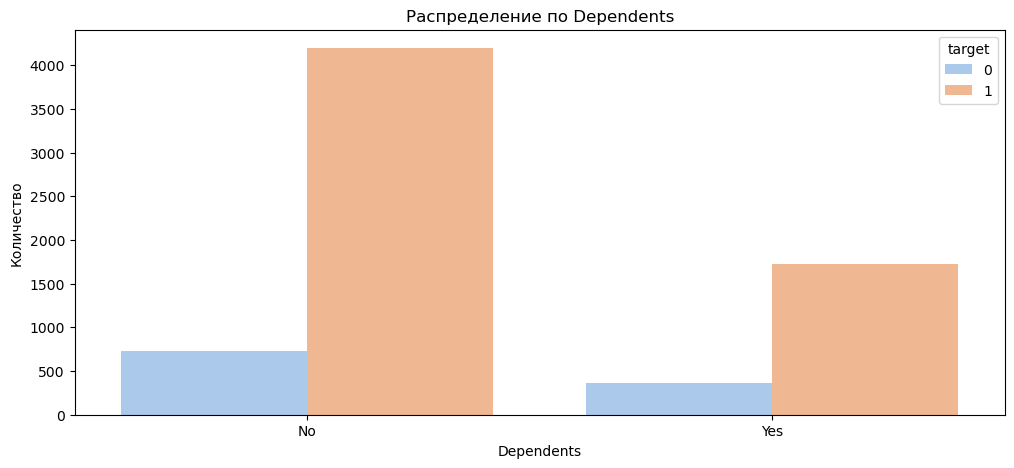

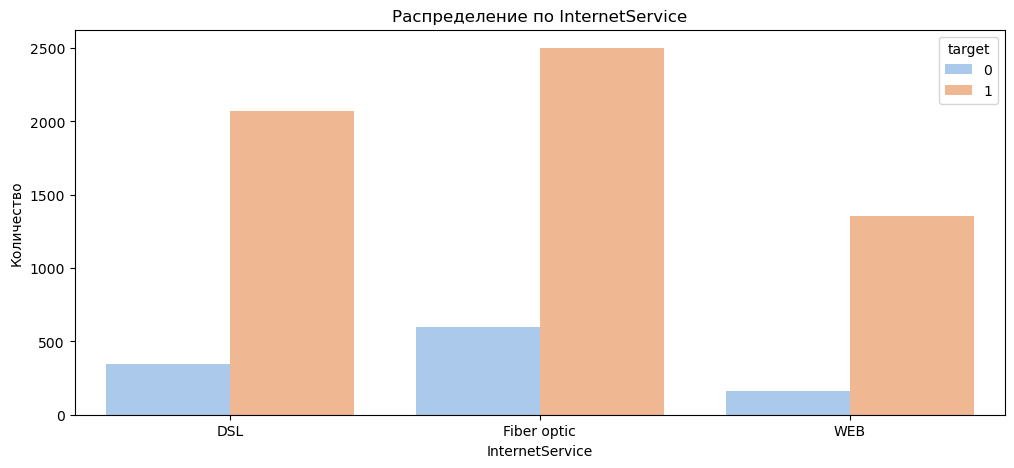

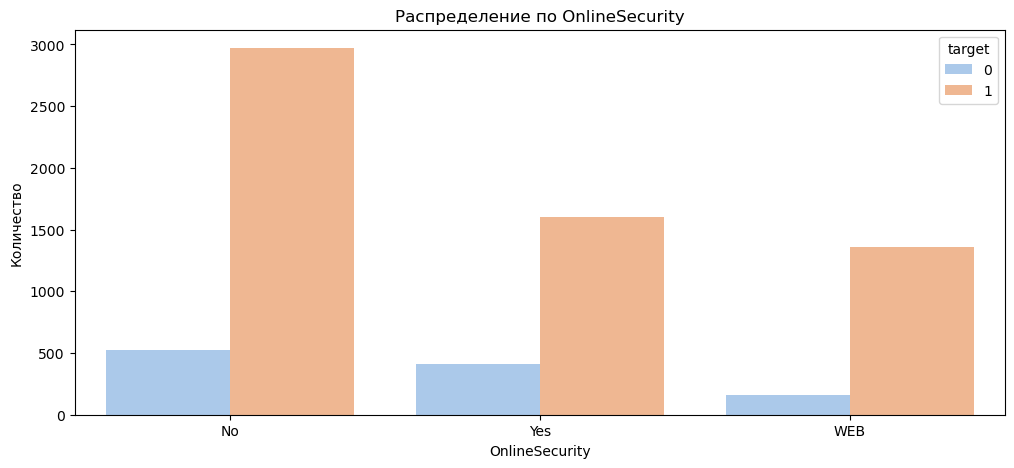

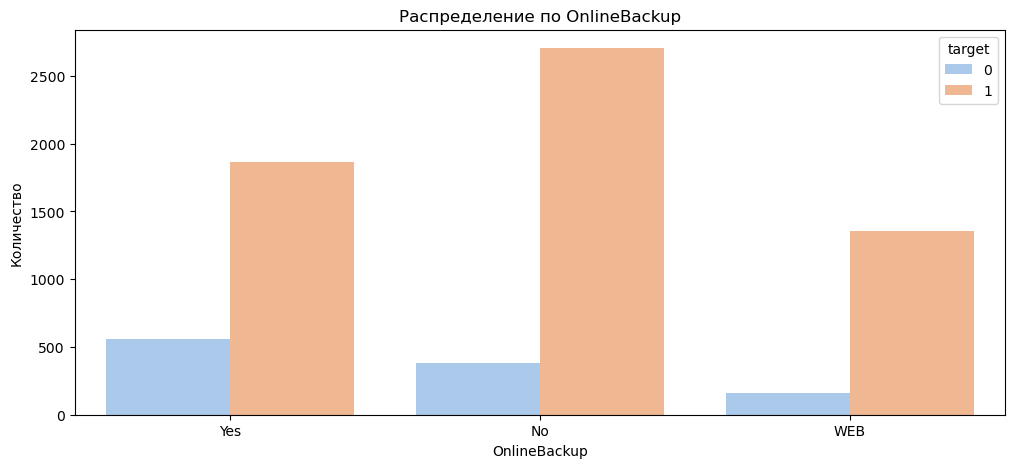

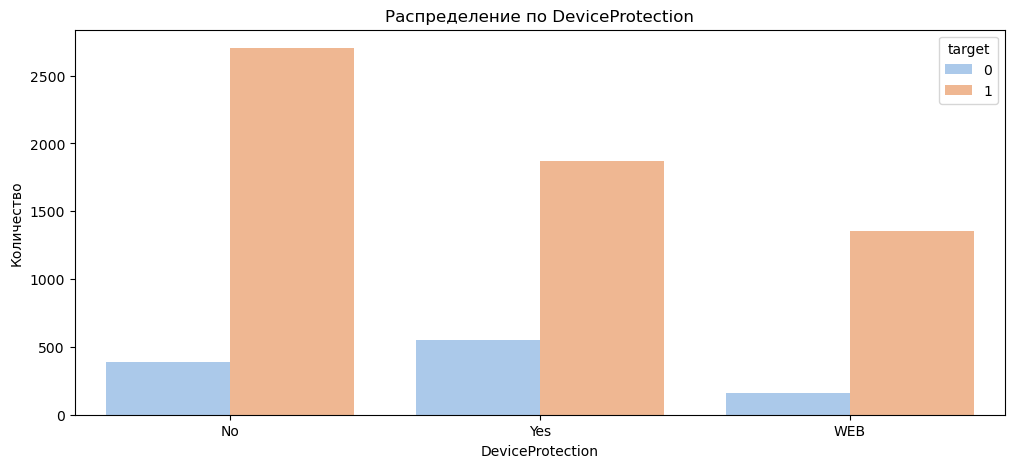

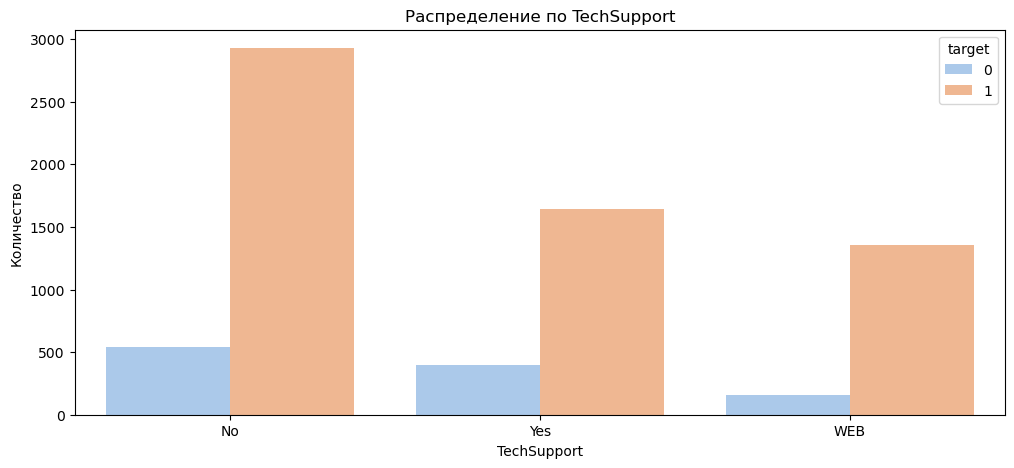

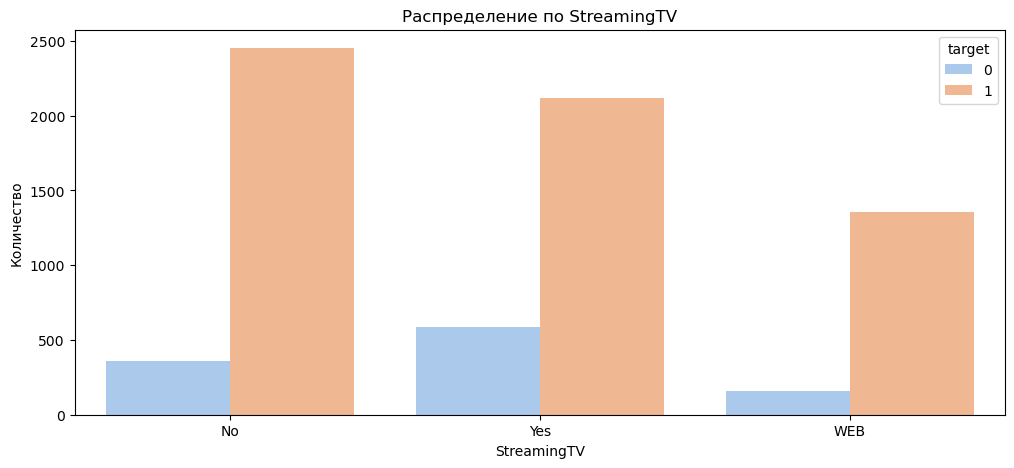

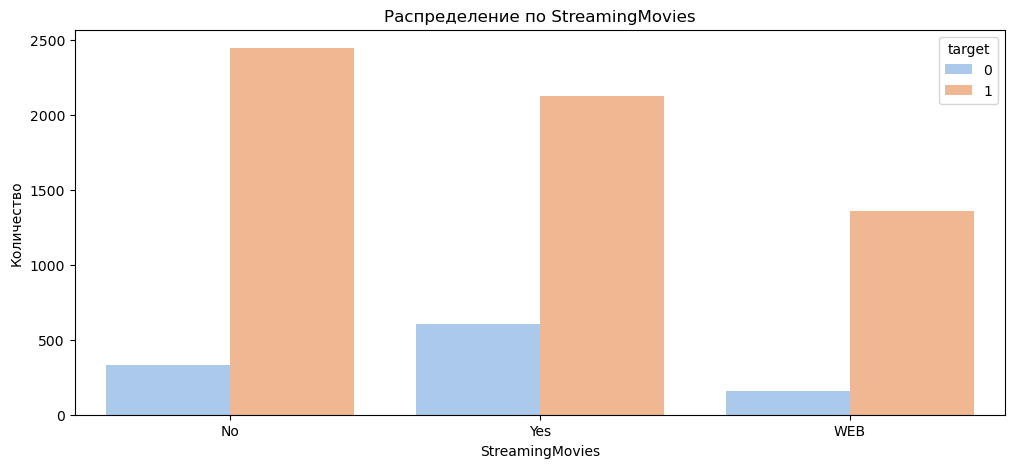

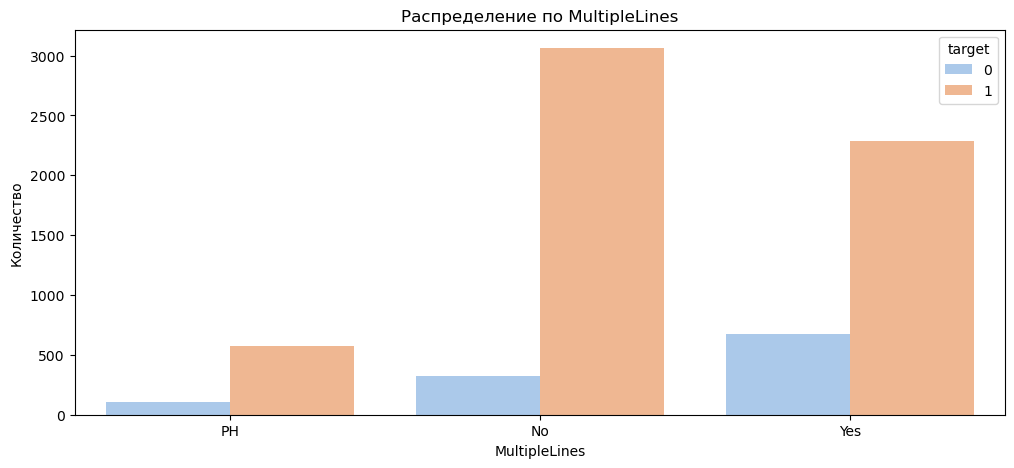

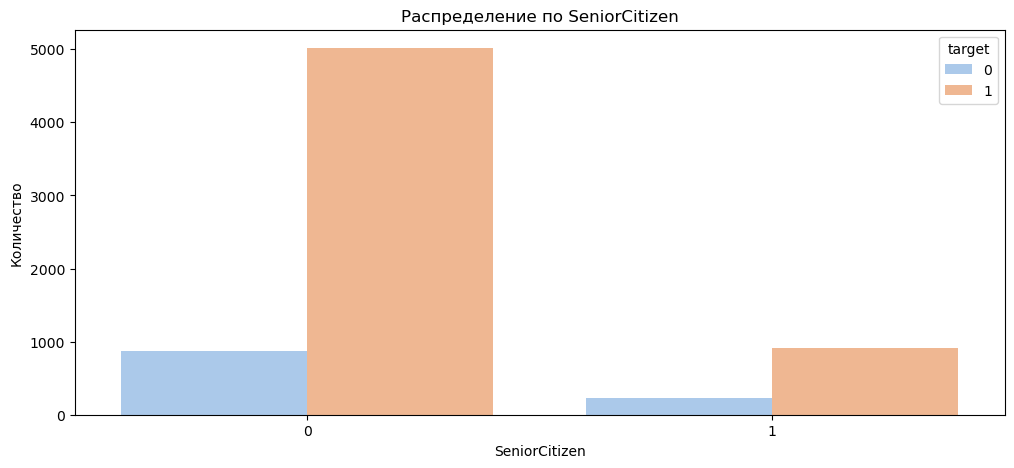

In [27]:
for i in categorical_columns:
    check_category(data, i)

Краткая сводка по гистограммам:
    
    - Большинство клиентов предпочитают способ оплаты Month-to_month (ежемесячная оплата). Отток почти одинаков при любом типе оплаты. 
    - Электронные оплаты популярнее
    - Самый популярный тип платежа - Electronic check
    - Распледеление по полу одинаковое
    - Людей не состоявших в браке чуть больше. Примечательно, что люди состоящие в браке, чаще прекращают договор об оказание услуг.  
    - Абонентов, у которых нет детей, значительно больше. 
    - Тип подключения оптоволокна - лидирует, однако у него и больший отток клиентов, но это может быть связано с тем, что в принципе больше клиентов выбирают волокно, нежели DSL подключение. 
    - Блокировку опасных сайтов не особо активно подключают. Опять же тут можно провести связь с пользователями, у которых есть дети, а как мы увидели выше на графике, то таких пользователей значительно меньше. 
    - Облачное хранилище тоже не так популярно. Тут можно выделить пару причин - доп, услуга = доп. деньги, клиенту попросту не нужно реззервное хранилище
    - Удивительно, но большинство пользователей не приобретают антивирус (хотя в нашей стране - это не удивительно). Возможно, клиент не понимает важность данного ПО, либо пользуется бесплатным антивирусом. 
    - Выделенная линия тех.поддержки также не совсем популярна среди абонентов. 
    - Стриминнговое телевидение почти догнала абонентов, которые его не используют. Тут также виден отток чуть бульше, у обладателей стрим.ТВ. 
    - Аналогичную ситуацию как и со стрим. ТВ можно увидеть в опции подключения каталога фильмов. 
    - Большая часть клиентов функцию подключение телефона к нескольким линиям одновременно - не приобретают. Однако у категории людей, которая использует данную опцию, отток чуть больше. 
    - Пенсионеров значительно меньше. 

## <a id='toc1_7_'></a>[Подготовка данных](#toc0_)

In [28]:
categorical_features = ['Type', 'PaperlessBilling', 'PaymentMethod', 'gender',
                        'Partner', 'Dependents', 'InternetService', 'OnlineSecurity',
                        'OnlineBackup', 'DeviceProtection', 'TechSupport',
                        'StreamingTV', 'StreamingMovies', 'MultipleLines']

# Конвертация категориальных столбцов в тип 'category'
for feature in categorical_features:
    data[feature] = data[feature].astype('category')

In [29]:
data.info()

In [30]:
features = data.drop('target', axis=1)
target = data['target']

In [31]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=RANDOM_STATE, stratify=target)

In [32]:
display(x_train.shape)
display(x_test.shape)

## <a id='toc1_8_'></a>[LGBM](#toc0_)

In [33]:
model_lgbm = LGBMClassifier(class_weight='balanced', random_state=RANDOM_STATE )

parameters = { 
    'n_estimators': [1000], 
    'max_depth': [8,16],
    'num_leaves': [8,16]}


grid_search_lgbm = GridSearchCV(model_lgbm, parameters, cv=5, scoring='roc_auc' )
grid_search_lgbm.fit(x_train, y_train)

best_model_lgbm = grid_search_lgbm.best_estimator_
best_params_lgbm = grid_search_lgbm.best_params_
best_roc_lgbm = grid_search_lgbm.best_score_
importance = best_model_lgbm.feature_importances_


print('Лучшая модель:', best_model_lgbm)
print('roc_auc:', best_roc_lgbm)
print('Лучшие параметры:', best_params_lgbm)

## <a id='toc1_9_'></a>[CatBoost](#toc0_)

In [34]:
categorical_features = (['Type', 
                         'PaperlessBilling', 
                         'PaymentMethod', 
                         'gender', 
                         'Partner', 
                         'Dependents', 
                         'InternetService', 
                         'OnlineSecurity', 
                         'OnlineBackup', 
                         'DeviceProtection', 
                         'TechSupport', 
                         'StreamingTV', 
                         'StreamingMovies', 
                         'MultipleLines'])

In [35]:
model_cat = CatBoostClassifier(auto_class_weights='Balanced', verbose=50, random_state=RANDOM_STATE, cat_features=categorical_features)

parameters = {
    'iterations': [100,200],
    'depth': [6,10]
}    
grid_search_cat = GridSearchCV(model_cat, parameters, cv=5, scoring='roc_auc')
grid_search_cat.fit(x_train, y_train)

best_model_cat = grid_search_cat.best_estimator_
best_params_cat = grid_search_cat.best_params_
best_roc_cat = grid_search_cat.best_score_


print('Лучшая модель:', best_model_cat)
print('roc_auc:', best_roc_cat)
print('Лучшие параметры:', best_params_cat)

In [36]:
# Выбор лучшей на основе валидации
table = {'Модели':
    ['LGBM', 'CatBoost'],
         'Параметры': [best_params_lgbm, best_params_cat ],
         'roc_auc valid':[best_roc_lgbm, best_roc_cat]
         
}

table = pd.DataFrame(table)
table.head()

Лучше и быстрее показала себя модель LGBM, ее и возьмем для проверки на тестовых данных. 

## <a id='toc1_10_'></a>[Тестирование](#toc0_)

In [37]:
predictions = best_model_lgbm.predict(x_test)
predictions_proba = best_model_lgbm.predict_proba(x_test)[:, 1]  
roc_auc = roc_auc_score(y_test, predictions_proba)

print('ROC AUC на тестовых данных:', roc_auc)

Необходимая метрика достигнута!

## <a id='toc1_11_'></a>[Важность признаков и матрица ошибок](#toc0_)

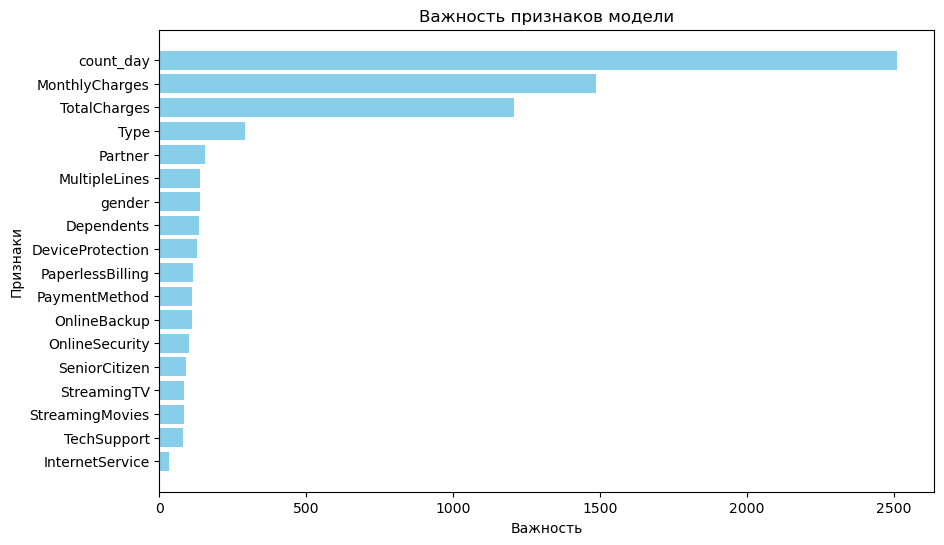

In [38]:
importance = best_model_lgbm.feature_importances_

sorted_idx = np.argsort(importance)[::-1]
labels = x_train.columns[sorted_idx]
plt.figure(figsize=(10, 6))
plt.barh(range(len(importance)), importance[sorted_idx], color='skyblue')
plt.yticks(range(len(importance)), labels) 
plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.title('Важность признаков модели')
plt.gca().invert_yaxis()  


- Наибольшую значимость, с очень большим разрывом от второго места, получил признак count_day (кол-во дней пользование сервисом). 
- На втором месте расположился признак MonthlyCharges (ежемесячные траты). Данный признак также имеет вес на принятие решений но уже значительно меньше. 
- Тройку финалистов закрывает признак TotalCharges (общие расходы абонента). 

Эти 3 признака значительно выделяются от остальных. 

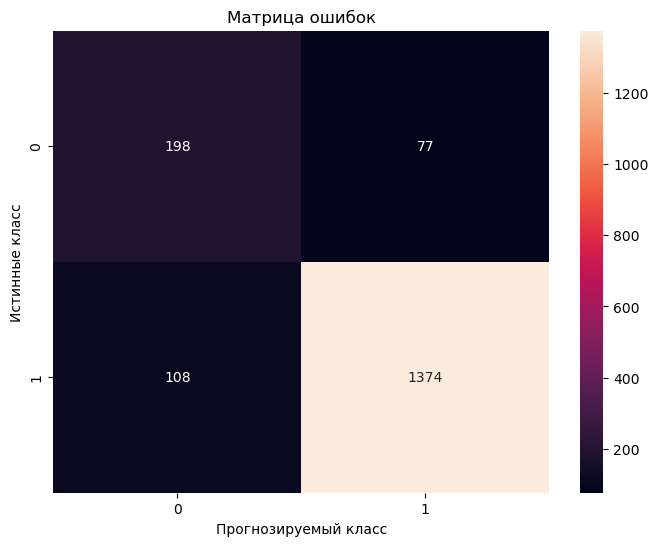

In [39]:
y_pred = best_model_lgbm.predict(x_test)
cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Матрица ошибок")
plt.ylabel('Истинные класс')
plt.xlabel('Прогнозируемый класс')
plt.show()

In [40]:
y_test.value_counts()

График матрицы ошибок показывает, что модель правильно классифицировала 1374 примера как положительные (True Positive) и 198 примеров как отрицательные (True Negative). Однако, модель также ошибочно классифицировала 108 примеров как положительные (False Positive) и 77 примеров как отрицательные (False Negative).

Процент ошибки на первом классе равен 7.28%
Процент ошибки на нулевом классе равен 28%

Можно сделать вывод, что модель ошибалась достаточно мало. Но лучше ее использовать для прогнозирования тех клиентов, кто не собирается прекращать договор. 

Таким образом получиться "отсеять" довольных клиентов и не тратить на них дополнительные силы и ресуры компании по удержанию  их (абонентов)  в пользователях. 

## <a id='toc1_12_'></a>[Вывод](#toc0_)

В ходе работы выполнили следующие этапы:

    - Загрузили и изучили датасеты. 
    При изучении пришли к выводу: 
        - В датасетах отстуствуют дубликаты и пропуски. 
        - Имеют разную размерность. 
        - Некоторые столбцы требуют преобразования в подходящий формат. 
        - Во всех датасетах есть общий столбец customerID - по которому в дальнейшем будет произведено объеденение данных. 
     - Произвели объединение датасетов в один с помощью метода megre() по столбцу customerID.
     - Количество строк не изменилось (7043).
     - После объединения появились пропуски у тех клиентов, которые не пользуются интернетом или телефоном. Дубликатов нет.
     - Заменили пропуски в столбце MultipleLines - на PH (PHONE) - только телефония
     - Заменили пропуски с интернет подключением на WEB - только интернет услуги.
     - Сформировали категориальный признак на основе столбца с датами окончания договоров клиентов. Где - 1 означает, что договор еще действует, а 0 - означаент что договор расторгнут. 
     - Вынесли категориальный признак в отдельный столбец 'target'.
     - Произвели в столбце EndDate замену данных, с 'NO', на дату выгрузки данных. 
     - Приобразовали типы данных:
             - Столбец target - int
             - Столбцы EndDate и BeginDate - в datetime
             - Столбец TotalCharges - в численный формат методом to_numeric
             
      - После преобразования столбца TotalCharges - были обнаружены и удалены 11 пропусков. Решение об удалении было принято на основе очень маленького количества строк с пропусками, которые не искозят исследования. 
      - Добавили новый признак 'count_day' в объединенный датасет который отображает количество дней пользования сервисом. 
      - Отбросили от дальнейшего исследования столбцы 'EndDate','BeginDate', 'customerID' - так как они больше не нужны для исследования.
      - После удаления столбцов, было обнаружено и удалено 4 дубликата. Малое количество данных - не повлияет на результат исследования. 
      - Изучили дисбаланс классов, он оказался весьма существенным (1 - 0.843341 \\ 0 - 0.156659). Наша метрика для исследования ROC AUC, которая устойчива к дисбалансу классов. Поэтому дополнительных действий по балансировке классов не проводилось (не считая попытки равномерно разделить данные на выборки и балансировка во время обучения моделей). 
      - Построили гистограмму расходов клиентов за месяц и пришли к выводу, что большая часть клиентов предпочитает использовать базовый тарифный план. 
      - Построили гистограмму общих расходов абонента, на которой увидили, что чем дороже "пакет" услуг, тем меньше их количество. Что дополнительно подкрепляет предыдущую гистограмму фактом, что большая часть клиентов использует базовые тарифы.
      - Выдели категориальные признаки: 
      
      'Type', 
      'PaperlessBilling', 
      'PaymentMethod', 
      'gender', 
      'Partner', 
      'Dependents', 
      'InternetService', 
      'OnlineSecurity', 
      'OnlineBackup', 
      'DeviceProtection', 
      'TechSupport', 
      'StreamingTV', 
      'StreamingMovies', 
      'MultipleLines'
      
      - Подготовили функцию для отрисовки графиков категориальных признаков и изучили графики. 
          
             Краткая сводка по гистограммам:
    
         - Большинство клиентов предпочитают способ оплаты Month-to_month (ежемесячная оплата). Отток почти одинаков при любом типе оплаты. 
         - Электронные оплаты популярнее
         - Самый популярный тип платежа - Electronic check
         - Распледеление по полу одинаковое
         - Людей не состоявших в браке чуть больше. Примечательно, что люди состоящие в браке, чаще прекращают договор об оказание услуг.  
         - Абонентов, у которых нет детей, значительно больше. 
         - Тип подключения оптоволокна - лидирует, однако у него и больший отток клиентов, но это может быть связано с тем, что в принципе больше клиентов выбирают волокно, нежели DSL подключение. 
         - Блокировку опасных сайтов не особо активно подключают. Опять же тут можно провести связь с пользователями, у которых есть дети, а как мы увидели выше на графике, то таких пользователей значительно меньше. 
         - Облачное хранилище тоже не так популярно. Тут можно выделить пару причин - доп, услуга = доп. деньги, клиенту попросту не нужно реззервное хранилище
         - Удивительно, но большинство пользователей не приобретают антивирус (хотя в нашей стране - это не удивительно). Возможно, клиент не понимает важность данного ПО, либо пользуется бесплатным антивирусом. 
         - Выделенная линия тех.поддержки также не совсем популярна среди абонентов. 
         - Стриминнговое телевидение почти догнала абонентов, которые его не используют. Тут также виден отток чуть бульше, у обладателей стрим.ТВ. 
         - Аналогичную ситуацию как и со стрим. ТВ можно увидеть в опции подключения каталога фильмов. 
         - Большая часть клиентов функцию подключение телефона к нескольким линиям одновременно - не приобретают. Однако у категории людей, которая использует данную опцию, отток чуть больше. 
         - Пенсионеров значительно меньше.  
    

- Затем приступили к подготовке данных для модели:

*На этом этапе были пропущены кодирование признаков так как у моделей есть встроенное кодирование*. 

        - Перевели категориальный признаки в тип category для LGBM
        - разделили датасет на обучающую и тестовую выборки, в масштабе 0.75 - train, 0.25 - test, использовали метод stratify для целевого признака target. Для равномерного распределения. 
        - Размерность обучающей \ тестовой выборки: (5271, 18) \ (1757, 18)
        - Обучили модель LGBM используя GridSearchCV с перебором параметров : 
        'n_estimators': [1000],
        'max_depth': [8,16],
        'num_leaves': [8,16]
        И кросс-валидацией cv=5
 
- Лучшие Параметры модели на кросс-валидации: LGBMClassifier(class_weight='balanced', max_depth=8, n_estimators=1000, num_leaves=8, random_state=201123)
    
    Данная модель показала ROC_AUC на валидации 0.8896
    
- Также была обучена модель CatBoost с помощью GridSearchCV, автобалансировкой классов, verbose=50, random_state=201123

Перебор параметров при поиске лучшей модели:

    'iterations': [100,200],
    'depth': [6,10]
    
Лучшие Параметры модели на кросс-валидации: {'depth': 6, 'iterations': 200}. 
    
     Данная модель показала ROC_AUC на валидации roc_auc: 0.8464
     
Так как при обучение и проверки моделей на кросс - валидации лучшую метрику показала модель LGBM - ее мы и взяли для проверки на тестовой выборке. 

Данные метрики лучше модели LGBM c параметрами class_weight='balanced', max_depth=8, n_estimators=1000, num_leaves=8, random_state=201123, ровняются 0.9079, что соответствует требованиям заказчика.

- Построили график важности признаков, на нем мы увидели следующее:
        
        - Наибольшую значимость, с очень большим разрывом от второго места, получил признак count_day (кол-во дней пользование сервисом).
        - На втором месте расположился признак MonthlyCharges (ежемесячные траты). Данный признак также имеет вес на принятие решений но уже значительно меньше.
        - Тройку финалистов закрывает признак TotalCharges (общие расходы абонента).
        
        Эти 3 признака значительно выделяются от остальных.
    
    
Построили матрицу ошибок. 

    - По построенному графику можно сделать следующий вывод:
    График матрицы ошибок показывает, что модель правильно классифицировала 1374 примера как положительные (True Positive) и 198 примеров как отрицательные (True Negative). Однако, модель также ошибочно классифицировала 108 примеров как положительные (False Positive) и 77 примеров как отрицательные (False Negative).

 - Процент ошибки на первом классе равен 7.28%
 - Процент ошибки на нулевом классе равен 28%

Можно сделать вывод, что модель ошибалась достаточно мало. Но лучше ее использовать для прогнозирования тех клиентов, кто не собирается прекращать договор. 

Таким образом получиться "отсеять" довольных клиентов и не тратить на них дополнительные силы и ресуры компании по удержанию  их (абонентов)  в пользователях. 